In [195]:
from pymongo import MongoClient,TEXT
import matplotlib.pyplot as plt
import urllib.parse
import pandas as pd
import urllib.robotparser
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/linuxperso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
client=MongoClient('172.24.0.3', port=27017)
performance={}
database="scrapping"
collection_sitemaps="sitemaps"
collection_htmls="htmls"

In [183]:
print("\nNb pages html :{}".format(client[database][collection_htmls].count_documents({})))


Nb pages html :2182901


La requête count_documents est lente car mongo doit tout parcourir 

In [184]:
list(client[database][collection_htmls].aggregate(
                                                    [ { "$sample": { "size": 1 } } ]
                                                    ))

[{'_id': ObjectId('65ad50191ad964f0c2f477b0'),
  'url': 'https://theintercept.com/wp-content/uploads/2019/05/GettyImages-869772780-incarceration-prayer-muslims-1558724153-e1558724225126.jpg',
  'mots_in_url': ['2019',
   'gettyimages',
   '869772780',
   'incarceration',
   'prayer',
   'muslims',
   '1558724153',
   'e1558724225126'],
  'has_been_scrapped': False,
  'id_media': 2684,
  'media_name': 'Intercept',
  'is_responding': True,
  'xml_source': 'https://theintercept.com/post-sitemap6.xml',
  'text': None}]

In [185]:
client[database][collection_htmls].create_index('mots_in_url')

'mots_in_url_1'

# Requete avec uniquement le match sur les éléments de l'array parsé

In [309]:
t1=time.time()
list_match=["white", "privilege"]#"france"#"climat"#"cop.?28"
list_no_match=[]
all=True

def match_document_v1(client, database, collection_htmls, list_match, all=False):
    if all:
        print("all element in list_match")
        return pd.DataFrame(list(client[database][collection_htmls].aggregate(
                                                        [
                                                            {
                                                                "$match" : 
                                                                {
                                                                    "$and":
                                                                        [
                                                                        {"mots_in_url": { "$all":  list_match }},
                                                                        {"mots_in_url": { "$nin":  list_no_match }}
                                                                        ]

                                                                },
                                                            },
                                                            { "$project": 
                                                                    { 
                                                                        "_id":0,
                                                                        "id_media": 1, 
                                                                        "media_name": 1, 
                                                                        "url" : 1, 
                                                                        "mots_in_url" :1,
                                                                        "xml_source" :1
                                                                    }
                                                            }
                                                        ]
                                                )
                                        )
        )
    else:
        print("one element atleast in list_match")
        return  pd.DataFrame(list(client[database][collection_htmls].aggregate(
                                                            [
                                                                {
                                                                    "$match" : 
                                                                    {
                                                                        "$and":
                                                                            [
                                                                            {"mots_in_url": { "$in":  list_match }},
                                                                            { "mots_in_url": { "$nin":  list_no_match }}
                                                                            ]

                                                                    },
                                                                },
                                                                { "$project": 
                                                                        { 
                                                                            "_id":0,
                                                                            "id_media": 1, 
                                                                            "media_name": 1, 
                                                                            "url" : 1, 
                                                                            "mots_in_url" :1,
                                                                            "xml_source" :1
                                                                        }
                                                                }
                                                            ]
                                                    )
                                            )
            )


df_urls_match_v1=match_document_v1(client, database, collection_htmls, list_match, all=all)
t2=time.time()
print(t2-t1)
print(len(df_urls_match_v1))
performance["match_sur_element_only"]=[len(df_urls_match_v1),t2-t1]

all element in list_match
0.047480106353759766
45


In [310]:
df_urls_match_v1.sample(20).loc[:, ["url", "xml_source", "mots_in_url"]]

,url,xml_source,mots_in_url
17,https://thespectator.com/topic/antifa-white-privilege-race-minneapolis/,https://thespectator.com/post-sitemap5.xml,"[topic, antifa, white, privilege, race, minneapolis]"
23,https://hotair.com/john-s-2/2022/01/11/california-high-school-teaches-white-straight-christian-students-to-check-their-privilege-n440839,https://hotair.com/post-sitemap4.xml,"[john, 2022, california, high, school, teaches, white, straight, christian, students, check, privilege, n440839]"
42,https://www.thedailybeast.com/florida-school-board-member-ann-murray-blames-hacker-for-white-privilege-meme,https://www.thedailybeast.com/sitemap-7.xml,"[florida, school, board, member, ann, murray, blames, hacker, white, privilege, meme]"
26,https://americanjournalnews.com/cartoon-white-terrorist-privilege-january-6-capitol-insurrection-sentencing-marijuana-laws/,https://americanjournalnews.com/post-sitemap7.xml,"[cartoon, white, terrorist, privilege, january, capitol, insurrection, sentencing, marijuana, laws]"
41,https://www.thedailybeast.com/white-privilege-is-real-i-know-i-lost-mine-after-911,https://www.thedailybeast.com/sitemap-7.xml,"[white, privilege, real, know, lost, mine, 911]"
9,https://www.schwartzreport.net/2008/09/20/this-is-your-nation-on-white-privilege/,https://www.schwartzreport.net/post-sitemap4.xml,"[2008, nation, white, privilege]"
32,https://blackpressusa.com/wp-content/uploads/2022/02/principal-forced-to-apologize-for-showing-video-about-white-privilege-Wf9QBnPK6Yg.jpg,https://blackpressusa.com/post-sitemap7.xml,"[2022, principal, forced, apologize, showing, white, privilege, wf9qbnpk6yg]"
33,https://blackpressusa.com/vaccine-distribution-another-example-of-white-privilege/,https://blackpressusa.com/post-sitemap7.xml,"[vaccine, distribution, another, example, white, privilege]"
5,https://blackpressusa.com/white-supremacy-voter-suppression-and-privilege/,https://blackpressusa.com/post-sitemap.xml,"[white, supremacy, voter, suppression, privilege]"
29,https://www.politico.com/blogs/politico-now/2007/06/leahy-conyers-ask-white-house-to-justify-executive-privilege-claim-002034,https://www.politico.com/sitemap-200706.xml,"[blogs, politico, 2007, leahy, conyers, ask, white, house, justify, executive, privilege, claim, 002034]"


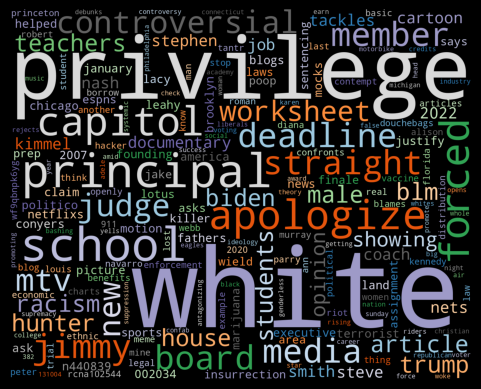

In [311]:
n=200
liste_parser=list(df_urls_match_v1.loc[:, "mots_in_url"].dropna())
series_word_freq = pd.Series([ x for xs in liste_parser for x in xs ]).value_counts().reset_index()
dictio_frequence=dict(zip(series_word_freq.loc[:, "index"], series_word_freq.loc[:, "count"]))


figure, axes = plt.subplots(1, 1, facecolor='k')
wcloud = WordCloud(width=1500, height=1200,  colormap='tab20c').generate_from_frequencies(dictio_frequence)
axes.imshow(wcloud)
axes.axis("off")
plt.show()


In [327]:
import requests
from bs4 import BeautifulSoup
#https://thesource.com/sitemap.xml
#https://americanjournalnews.com/post-sitemap7.xml
soup=BeautifulSoup(requests.get("https://www.thedailybeast.com/sitemap-7.xml").content,features="lxml")
list(map(lambda x:[x.select("loc")[0].get_text(), x.select("lastmod")[0].get_text() if len(x.select("lastmod")) else None],soup.select("url")))

[['https://www.thedailybeast.com/samuel-paty-killing-sets-off-police-raids-across-france-after-teachers-fatwa-beheading',
  '2020-10-19T10:22:33.500Z'],
 ['https://www.thedailybeast.com/the-views-joy-behar-sounds-off-on-fighting-with-meghan-mccain-and-creepy-ted-cruz',
  '2020-10-19T09:34:10.763Z'],
 ['https://www.thedailybeast.com/twice-toothpaste-is-delicious-and-healthy',
  '2020-10-19T09:30:00.000Z'],
 ['https://www.thedailybeast.com/cody-bellinger-home-run-seals-the-deal-for-the-la-dodgers-heading-to-third-world-series-in-four-years',
  '2020-10-19T09:28:06.493Z'],
 ['https://www.thedailybeast.com/bolivia-election-appears-won-by-luis-arce-of-ex-president-evo-morales-socialist-party-in-do-over-vote',
  '2020-10-19T09:15:43.371Z'],
 ['https://www.thedailybeast.com/richer-poorer-sweater-review',
  '2020-10-19T09:00:00.000Z'],
 ['https://www.thedailybeast.com/worried-the-van-life-movement-is-too-white-for-you-heres-some-advice-from-bipoc-van-lifers',
  '2020-10-19T08:51:19.798Z'],
 ['